# Topic Modelling of Material Event Disclosures (Form 8-K, Item 8.01)

**Pipeline**:
- [sec-api.io](https://sec-api.io/docs/sec-filings-item-extraction-api): Extract and download text sections from Item 8.01 disclosures
- [OpenAI Embeddings API](https://platform.openai.com/docs/guides/embeddings#embedding-models): Create embedding vectors for each text section
- [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html): Reduce dimensionality of embeddings (1536 -> 5D)
- [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html): Unsupervised clustering of reduced embeddings
- [BERTopic](https://maartengr.github.io/BERTopic/index.html) to create topics from the clusters and visualize them

## What are Form 8-K disclosures?

- Publicly traded U.S. companies must file Form 8-K filings with the SEC when certain events occur that are important to shareholders.
- Examples of events: executive changes, bankruptcy, acquisition, etc.
- 8-K filings are published within 4 days of the event. Its publication is triggered by the occurence of an event, not by a time schedule.
- The filing is divided into sections labeled with item numbers (e.g., Item 1.01, Item 5.02). Each item number corresponds to a specific type of event.
- Item 8.01 is a "catch-all" category for events relevant to security holders but not specified elsewhere in the form.

### Examples:

Item 1.01 - Entry into an agreement
- Mergers and acquisitions, commercial contracts with suppliers, debt agreements, etc.

Item 2.02 - Earnings release (quarterly or annual results)
- Earnings releases including financial performance of company (income statement, balance sheet, etc.)

Item 4.02 - Previously issued financial statements can no longer be relied upon
- Error in financial statements was discovered, information about the affected financial statements, the impact of the errors, etc.

Our focus: Item 8.01 - Other events

## Helper Functions

- For simplicity, I already downloaded all Item 8.01 text sections and created embedding vectors for each section
- The helper functions below are used to load the text sections and embeddings from disk into memory

In [53]:
# load all JSON files from ./data/8k-items/item-8-01/embeddings/<year>/<cik>/...json
# load all TXT files from ./data/8k-items/item-8-01/content/<year>/<cik>/...txt

# pip install matplotlib pandas numpy python-dotenv umap-learn hdbscan openai bertopic
import os
import json
import textwrap
import html
import pandas as pd
import numpy as np
from dotenv import load_dotenv

load_dotenv()  # load .env file

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")


def print_text(text):
    paragraphs = text.splitlines()
    wrapped_paragraphs = [textwrap.fill(p, width=150) for p in paragraphs]
    wrapped_text = "\n".join(wrapped_paragraphs)
    decoded_text = html.unescape(wrapped_text)
    print(decoded_text)


def load_json_files(directory):
    data = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".json"):
                file_path = os.path.join(root, file)
                with open(file_path, "r") as f:
                    try:
                        content = json.load(f)
                        content["file_path"] = file_path
                        data.append(content)
                    except json.JSONDecodeError as e:
                        print(f"Error decoding JSON from {file_path}: {e}")
    return data


def load_txt_files(directory):
    data = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                with open(file_path, "r") as f:
                    try:
                        content = f.read()
                        data.append(content)
                    except Exception as e:
                        print(f"Error reading TXT from {file_path}: {e}")
    return data


def load_all_embeddings():
    base_dir = "../data/8k-items/item-8-01/embeddings"
    all_data = []
    for year in os.listdir(base_dir):
        if not year in ["2023"]:
            continue
        year_dir = os.path.join(base_dir, year)
        if os.path.isdir(year_dir):
            for cik in os.listdir(year_dir):
                cik_dir = os.path.join(year_dir, cik)
                if os.path.isdir(cik_dir):
                    data = load_json_files(cik_dir)
                    all_data.extend(data)
    return all_data


def load_dataset():
    raw_embeddings = load_all_embeddings()

    embeddings_df = pd.DataFrame(raw_embeddings)

    embeddings_df["embeddings"] = embeddings_df["data"].apply(
        lambda x: x[0]["embedding"] if isinstance(x, list) and len(x) > 0 else None
    )
    embeddings_df["content"] = embeddings_df["file_path"].apply(
        lambda x: (
            load_txt_files(os.path.dirname(x.replace("embeddings", "content")))[0]
            if os.path.exists(os.path.dirname(x.replace("embeddings", "content")))
            else None
        )
    )
    embeddings_df["accessionNo"] = embeddings_df["file_path"].apply(
        lambda x: x.split("/")[-1].split("-")[0]
    )
    embeddings_df = embeddings_df.drop_duplicates(subset=["content"])
    embeddings_df = embeddings_df.reset_index(drop=True)

    return embeddings_df[
        ["file_path", "embeddings", "content", "accessionNo"]
    ].reset_index(drop=True)

## Dataset Loading

- Load finalized dataset into memory
- Dataset includes a sample of ~800 Item 8.01 text sections from 2023 and their respective embeddings

In [20]:
dataset = load_dataset()

print(f"Loaded {len(dataset)} embeddings")
print("Dimension of the embeddings:", len(dataset['embeddings'][0]))

Loaded 807 embeddings
Dimension of the embeddings: 1536


In [21]:
dataset

,file_path,embeddings,content,accessionNo
0,../data/8k-items/item-8-01/embeddings/2023/000...,"[-0.02210092, -0.015903888, 0.017384594, 0.030...",Item 8.01. Other Events . \n\n&#8203; \n\nOn ...,000161198323000009
1,../data/8k-items/item-8-01/embeddings/2023/000...,"[0.006691796, 0.004263799, 0.015818167, -0.009...",Item 8.01 Other Events. \n\nBandwidth announc...,000151441623000050
2,../data/8k-items/item-8-01/embeddings/2023/000...,"[0.07643277, 0.006872245, 0.07082075, 0.033274...",Item 8.01 Other Events. \n\nThe three paragra...,000111061123000014
3,../data/8k-items/item-8-01/embeddings/2023/000...,"[0.020135557, 0.039088987, 0.05151445, 0.00129...",Item 8.01. Other Events \n\nIn accordance wit...,000161869723000007
4,../data/8k-items/item-8-01/embeddings/2023/000...,"[0.0053011575, 0.047115248, 0.04658928, 0.0262...",Item 8.01 Other Events \n\nCredit Agreement R...,000160971123000116
...,...,...,...,...
802,../data/8k-items/item-8-01/embeddings/2023/000...,"[0.022473125, 0.012677313, 0.0005933445, 0.038...","ITEM 8.01 OTHER EVENTS. \n\nOn February 4, 20...",000101628123000048
803,../data/8k-items/item-8-01/embeddings/2023/000...,"[-0.0039996565, 0.02207242, 0.05903209, 0.0241...",ITEM 8.01. OTHER EVENTS \n\nNewmont Corporati...,000116472723000035
804,../data/8k-items/item-8-01/embeddings/2023/000...,"[0.01852244, 0.012341683, 0.0021566546, 0.0156...","Item 8.01 Other Events \n\nOn November 2, 202...",000104869523000032
805,../data/8k-items/item-8-01/embeddings/2023/000...,"[0.022999143, -0.016711706, 0.06586056, 0.0549...","Item 8.01. Other Events. \n\nOn July 6, 2023,...",000110820523000056


In [52]:
print('### Example content ###')
print_text(dataset.loc[0, 'content'])

### Example content ###
 Item 8.01. Other Events .

​

On February 21, 2023, Liberty Broadband Corporation (“Liberty Broadband”), issued a press release announcing the commencement of its cash
tender offers to purchase any and all of each of the $14,536,000 outstanding aggregate principal amount of Grizzly Merger Sub 1, LLC’s, a wholly
owned subsidiary of Liberty Broadband, 1.75% Exchangeable Senior Debentures due 2046 (the “1.75% Debentures”), the $575,000,000
outstanding aggregate principal amount of Liberty Broadband’s 2.75% Exchangeable Senior Debentures due 2050 (the “2.75% Debentures”)
and the $825,000,000 outstanding aggregate principal amount of Liberty Broadband’s 1.25% Exchangeable Senior Debentures due 2050 (the
“1.25% Debentures” and, together with the 1.75% Debentures and the 2.75% Debentures, the “Debentures”), subject to certain
conditions. A copy of the press release announcing the tender offers is attached hereto as Exhibit 99.1 and incorporated by reference herein.

T

## Reduce Dimensionality

- Use UMAP to reduce embeddings from 1536 dimensions to 5 dimensions

In [ ]:
from umap import UMAP

# reduce embeddings from 1536 dimenions to 5 dimenions
n_dim = 5
umap_model = UMAP(n_components=n_dim, min_dist=0.0, metric="cosine", random_state=42)

reduced_embeddings_n_5 = umap_model.fit_transform(dataset["embeddings"].tolist())

## Cluster Reduced Embeddings

- Use HDBSCAN for unsupervised clustering of the reduced embeddings
- Minimum cluster size of 10

In [ ]:
from hdbscan import HDBSCAN

# fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=10, metric="euclidean", cluster_selection_method="eom"
).fit(reduced_embeddings_n_5)

clusters = hdbscan_model.labels_

print(f"Number of clusters: {len(set(clusters)) - (1 if -1 in clusters else 0)}")

Number of clusters: 13


## Inspecting the Clusters

- First documents in sample cluster deal with NASDAQ compliance issues

In [ ]:
# print first documents in sample cluster
cluster = 1

for index in np.where(clusters == cluster)[0][:2]:
    print_text(dataset.loc[index, "content"][:500] + "...")
    print("#" * 50)

 Item 8.01 Other Events.

Regain of Compliance with Nasdaq Listing Rule 5550(b)(1)

As previously disclosed, on March 20, 2023, HeartBeam, Inc. (the “ Company ”) received a notification letter from The Nasdaq Stock Market
LLC (the “ Nasdaq ”) indicating that the Company was not in compliance with Nasdaq’s Listing Rule 5550(b)(1) because the Company
reported in its Form 10-K for the year ended December 31, 2022 stockholders’ equity of $2,374,000, and, as a re...
##################################################
 Item 8.01

Other Events.

 

As previously disclosed, on November 28, 2023, Avinger, Inc. (the “Company”) requested and was granted a hearing before the Nasdaq
Hearings Panel (the “Panel”), which hearing was initially scheduled for March 14, 2024. The Company’s request for a hearing stayed
any further action by The Nasdaq Stock Market LLC (“Nasdaq”) with respect to the Company’s listing at least until the hearing is
held and any extension t...
##################################

## Visualize Clusters

- Visualization is only practical in 2D or 3D; it does not work for higher dimensions like 1536 (the size of the embeddings).
- Use UMAP to reduce the 1536-dimensional embeddings down to 2 dimensions (x and y axes).
- Plot the clusters identified in 5D space, on a 2D plane for easier interpretation.

In [ ]:
# reduce 1536-dimensional embeddings to 2 dimensions for visualization
reduced_embeddings_n_2 = UMAP(
    n_components=2, min_dist=0.0, metric="cosine", random_state=42
).fit_transform(dataset["embeddings"].tolist())

dataset['x'] = reduced_embeddings_n_2[:, 0]
dataset['y'] = reduced_embeddings_n_2[:, 1]
dataset["cluster"] = [str(c) for c in clusters]

clusters_df = dataset.loc[dataset.cluster != "-1", :]
outliers_df = dataset.loc[dataset.cluster == "-1", :]

In [27]:
clusters_df

,file_path,embeddings,content,accessionNo,x,y,cluster
0,../data/8k-items/item-8-01/embeddings/2023/000...,"[-0.02210092, -0.015903888, 0.017384594, 0.030...",Item 8.01. Other Events . \n\n&#8203; \n\nOn ...,000161198323000009,1.059331,3.693532,12
2,../data/8k-items/item-8-01/embeddings/2023/000...,"[0.07643277, 0.006872245, 0.07082075, 0.033274...",Item 8.01 Other Events. \n\nThe three paragra...,000111061123000014,10.074734,4.479414,0
3,../data/8k-items/item-8-01/embeddings/2023/000...,"[0.020135557, 0.039088987, 0.05151445, 0.00129...",Item 8.01. Other Events \n\nIn accordance wit...,000161869723000007,9.155782,3.657246,0
4,../data/8k-items/item-8-01/embeddings/2023/000...,"[0.0053011575, 0.047115248, 0.04658928, 0.0262...",Item 8.01 Other Events \n\nCredit Agreement R...,000160971123000116,-0.282887,2.633082,10
5,../data/8k-items/item-8-01/embeddings/2023/000...,"[0.06891989, -0.0036731497, 0.038930554, 0.025...","Item 8.01 Other Events \n\nOn February 24, 20...",000158773223000052,9.369566,4.750178,0
...,...,...,...,...,...,...,...
800,../data/8k-items/item-8-01/embeddings/2023/000...,"[0.010682319, 0.02873441, 0.064966984, 0.00759...",Item 8.01 Other Events. \n\nESTIMATED PER SHA...,000163297023000028,-1.729474,2.616675,8
801,../data/8k-items/item-8-01/embeddings/2023/000...,"[0.035607353, 0.013134976, 0.04448197, 0.01894...","Item 8.01. Other Events \n\n(New York, NY) &#...",000143710723000121,2.174681,1.532412,11
802,../data/8k-items/item-8-01/embeddings/2023/000...,"[0.022473125, 0.012677313, 0.0005933445, 0.038...","ITEM 8.01 OTHER EVENTS. \n\nOn February 4, 20...",000101628123000048,-0.370978,1.858934,10
804,../data/8k-items/item-8-01/embeddings/2023/000...,"[0.01852244, 0.012341683, 0.0021566546, 0.0156...","Item 8.01 Other Events \n\nOn November 2, 202...",000104869523000032,3.223566,0.845457,6


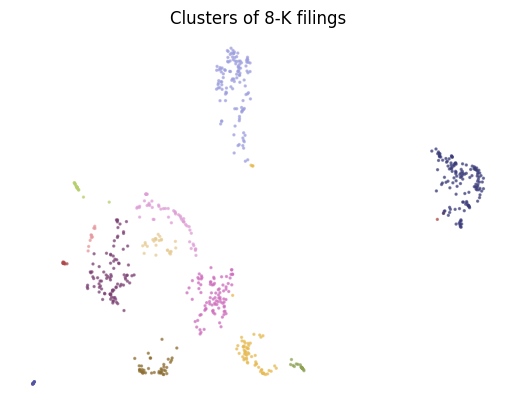

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(
    clusters_df.x,
    clusters_df.y,
    c=clusters_df.cluster.astype(int),
    alpha=0.6,
    s=2,
    cmap="tab20b",
)
plt.axis("off")
plt.title("Clusters of 8-K filings")
plt.show()

## Add Cluster Labels

In [ ]:
import openai
from bertopic import BERTopic
from bertopic.representation import OpenAI

prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short topic label in the following format:
topic: <short topic label>
"""

# update topic representations using GPT-4o-mini
client = openai.OpenAI(api_key=OPENAI_API_KEY)

representation_model = OpenAI(
    client, model="gpt-4o-mini", exponential_backoff=True, chat=True, prompt=prompt
)

topic_model = BERTopic(
    representation_model=representation_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True,
).fit(dataset['content'], np.array(dataset['embeddings'].tolist()))

2025-04-29 03:37:08,745 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-29 03:37:10,491 - BERTopic - Dimensionality - Completed ✓
2025-04-29 03:37:10,492 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-29 03:37:10,503 - BERTopic - Cluster - Completed ✓
2025-04-29 03:37:10,505 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 14/14 [00:20<00:00,  1.50s/it]
2025-04-29 03:37:31,717 - BERTopic - Representation - Completed ✓


In [44]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,128,-1_Risks and Proposed Transactions in Corporat...,[Risks and Proposed Transactions in Corporate ...,[ Item 8.01 Other Events. \n\n&#160; \n\nHS3 A...
1,0,136,0_Quarterly and Preferred Stock Dividends Anno...,[Quarterly and Preferred Stock Dividends Annou...,[ ITEM 8.01. &#160; Other Events \n\nOn March ...
2,1,119,1_Stock Repurchase and Valuation Updates,[Stock Repurchase and Valuation Updates],"[ Item 8.01 Other Events. On February 27, 2023..."
3,2,92,2_Bankruptcy Proceedings and Corporate Updates,[Bankruptcy Proceedings and Corporate Updates],[ Item 8.01 &#160; Other Events. \n\nOn Octobe...
4,3,91,3_Press Releases and Financial Announcements b...,[Press Releases and Financial Announcements by...,"[ Item 8.01. Other Events. \n\nOn July 24, 202..."
5,4,60,4_Executive Appointments and Board Changes in ...,[Executive Appointments and Board Changes in 2...,[ Item 8.01. Other Events. \n\n&#160; \n\nOn D...
6,5,52,5_Notes Offerings and Debt Management,[Notes Offerings and Debt Management],[ Item 8.01 Other Events. \n\nThe Company expe...
7,6,40,6_Clinical Trials and Drug Development Updates,[Clinical Trials and Drug Development Updates],"[ Item 8.01 Other Events. \n\nOn June 15, 2023..."
8,7,25,7_Securities Offerings and Underwriting Agreem...,[Securities Offerings and Underwriting Agreeme...,"[ Item 8.01. Other Information \n\nOn May 4, 2..."
9,8,17,8_Annual Stockholder Meetings and Proposal Dea...,[Annual Stockholder Meetings and Proposal Dead...,"[ Item 8.01 Other Events \n\nBARK, Inc. (the &..."


In [45]:
fig = topic_model.visualize_documents(
    dataset['accessionNo'],
    reduced_embeddings=reduced_embeddings_n_2,
    width=1200,
    height=600,
    hide_annotations=True
)
fig.update_layout(font=dict(size=12))